In [1]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os, glob
import tables
import pandas as pd
import matplotlib
from scipy.optimize import curve_fit

def quadratic_func(x, a, b, c):
    return a * x**2 + b * x + c
    
pd.set_option('display.max_columns', None)

# Display settings for Jupyter Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Importing custom utility functions
sys.path.insert(0, os.getcwd() + "/../scripts/")
import auxiliar as aux
import lstpipeline

### Paths to data and results

In [2]:
# Root path of this script
root = os.getcwd() + "/"
# Objects directory
root_objects = root + "objects/"

# Directory of all the night-wise datachecks
root_dchecks = "/fefs/aswg/workspace/abelardo.moralejo/data/datachecks/night_wise/DL1_datacheck_"
# Weather station file
ws_database = root_objects + "WS2003-23.h5"

# Some filenames -------------------
# Filename of the datacheck dictionary
fname_datacheck_dict = root_objects + "tmp_datacheck_dict.pkl"

# Flags for computing or not different parts
# Compute the datacheck dictionary
compute_datacheck_dict = True

# Create needed folders
for dir in [root_objects]:
    if not os.path.exists(dir):
        os.makedirs(dir)

### Extracting dates and parameters of all runs/subruns

In [3]:
%%time
if compute_datacheck_dict:

    run_number   = [] # Run numbers
    srun_number  = [] # Subrun numbers
    timestamps   = [] # Timestamps of each subrun
    time_elapsed = [] # Elapsed time of each subrun
    mean_azimuth = [] # Mean azimuth of each run
    mean_zenith_distance = [] # Mean zenith of each run
    zd_corrected_intensity_at_half_peak_rate = [] # ZD corrected intensity at half peak rate
    zd_corrected_cosmics_rate_at_422_pe = [] # ZD corrected cosmics rate at 422 pe
    zd_corrected_delta_cosmics_rate_at_422_pe = [] # ZD corrected delta cosmics rate at 422 pe
    cosmics_rate_at_422_pe = [] # ZD corrected cosmics rate at 422 pe
    delta_cosmics_rate_at_422_pe = [] # ZD corrected delta cosmics rate at 422 pe
    zd_corrected_cosmics_spectral_index = [] # ZD corrected cosmics spectral index
    cosmics_spectral_index = [] # ZD corrected cosmics spectral index
    zd_corrected_delta_cosmics_spectral_index = [] # ZD corrected delta cosmics spectral index
    light_yield = [] # Light yield

    # All the datachecks for all the nights
    dchecks = np.sort(glob.glob(root_dchecks + "*.h5"))

    # We iterate over all the datachecks
    for i, dcheck in enumerate(dchecks[:]):

        print(f"Analysing... {i:3}/{len(dchecks)}") if i % 30 == 0 else None

        # The datacheck file of the run summary (runwise)
        ds = pd.read_hdf(dcheck, key="runsummary")
        # The datacheck file of the intensity spectrums (subrunwise)
        di = pd.read_hdf(dcheck, key="cosmics_intensity_spectrum")
        
        # Iterating over all the entries of each night, the subruns
        for j in range(len(ds)):

            # Reference run number
            runref = ds["runnumber"].iloc[j]
            
            # Intensity datacheck for only the subruns of the reference run
            di_run = di.query(f"runnumber == {runref}")
            
            # Subrun iteration and storing all the data we are interested in
            for k in range(len(di_run)):

                run_number.append(runref)
                srun_number.append(di_run["subrun"].iloc[k])
                timestamps.append(datetime.fromtimestamp(di_run["time"].iloc[k]))
                time_elapsed.append(di_run["corrected_elapsed_time"].iloc[k])
                mean_azimuth.append(ds["mean_azimuth"].iloc[j])
                mean_zenith_distance.append(np.arccos(di_run["cos_zenith"].iloc[k]))
                zd_corrected_intensity_at_half_peak_rate.append(di_run["ZD_corrected_intensity_at_half_peak_rate"].iloc[k])
                zd_corrected_cosmics_rate_at_422_pe.append(di_run["ZD_corrected_cosmics_rate_at_422_pe"].iloc[k])
                zd_corrected_delta_cosmics_rate_at_422_pe.append(di_run["ZD_corrected_delta_cosmics_rate_at_422_pe"].iloc[k])
                cosmics_rate_at_422_pe.append(di_run["cosmics_rate_at_422_pe"].iloc[k])
                delta_cosmics_rate_at_422_pe.append(di_run["delta_cosmics_rate_at_422_pe"].iloc[k])
                zd_corrected_cosmics_spectral_index.append(di_run["ZD_corrected_cosmics_spectral_index"].iloc[k])
                cosmics_spectral_index.append(di_run["cosmics_spectral_index"].iloc[k])
                zd_corrected_delta_cosmics_spectral_index.append(di_run["delta_cosmics_spectral_index"].iloc[k])
                light_yield.append(di_run["light_yield"].iloc[k])            

    print(f"Analysing... {len(dchecks):3}/{len(dchecks)}\n")

    # Now we are going to sort looking to the timestamps
    _, run_number = aux.sort_based(run_number, timestamps)
    _, srun_number = aux.sort_based(srun_number, timestamps)
    _, time_elapsed = aux.sort_based(time_elapsed, timestamps)
    _, mean_azimuth = aux.sort_based(mean_azimuth, timestamps)
    _, mean_zenith_distance = aux.sort_based(mean_zenith_distance, timestamps)
    _, zd_corrected_intensity_at_half_peak_rate = aux.sort_based(zd_corrected_intensity_at_half_peak_rate, timestamps)
    _, zd_corrected_cosmics_rate_at_422_pe = aux.sort_based(zd_corrected_cosmics_rate_at_422_pe, timestamps)
    _, zd_corrected_delta_cosmics_rate_at_422_pe = aux.sort_based(zd_corrected_delta_cosmics_rate_at_422_pe, timestamps)
    _, cosmics_rate_at_422_pe = aux.sort_based(cosmics_rate_at_422_pe, timestamps)
    _, delta_cosmics_rate_at_422_pe = aux.sort_based(delta_cosmics_rate_at_422_pe, timestamps)
    _, zd_corrected_cosmics_spectral_index = aux.sort_based(zd_corrected_cosmics_spectral_index, timestamps)
    _, cosmics_spectral_index = aux.sort_based(cosmics_spectral_index, timestamps)
    _, zd_corrected_delta_cosmics_spectral_index = aux.sort_based(zd_corrected_delta_cosmics_spectral_index, timestamps)
    timestamps, light_yield = aux.sort_based(light_yield, timestamps)

    # Creating the data dictionary
    dict_dcheck = {
        "run" : np.array(run_number),
        "srun" : np.array(srun_number),
        "time" : np.array(timestamps),
        "telapsed" : np.array(time_elapsed),
        "az" : np.rad2deg(mean_azimuth),
        "zd" : np.rad2deg(mean_zenith_distance),
        "ZD_corrected_intensity_at_half_peak_rate" : np.array(zd_corrected_intensity_at_half_peak_rate),
        "ZD_corrected_cosmics_rate_at_422_pe" : np.array(zd_corrected_cosmics_rate_at_422_pe),
        "ZD_corrected_delta_cosmics_rate_at_422_pe" : np.array(zd_corrected_delta_cosmics_rate_at_422_pe),
        "cosmics_rate_at_422_pe" : np.array(cosmics_rate_at_422_pe),
        "delta_cosmics_rate_at_422_pe" : np.array(delta_cosmics_rate_at_422_pe),
        "ZD_corrected_cosmics_spectral_index" : np.array(zd_corrected_cosmics_spectral_index),
        "cosmics_spectral_index" : np.array(cosmics_spectral_index),
        "delta_cosmics_spectral_index" : np.array(zd_corrected_delta_cosmics_spectral_index),
        "light_yield" : np.array(light_yield)
    }        

    # Saving the objects in the objects directory
    with open(fname_datacheck_dict, 'wb') as f:
        pickle.dump(dict_dcheck, f, pickle.HIGHEST_PROTOCOL)  
else:
    # To read the file:
    with open(fname_datacheck_dict, 'rb') as f:
            dict_dcheck = pickle.load(f)    

Analysing...   0/529
Analysing...  30/529
Analysing...  60/529
Analysing...  90/529
Analysing... 120/529
Analysing... 150/529
Analysing... 180/529
Analysing... 210/529
Analysing... 240/529
Analysing... 270/529
Analysing... 300/529
Analysing... 330/529
Analysing... 360/529
Analysing... 390/529
Analysing... 420/529
Analysing... 450/529
Analysing... 480/529
Analysing... 510/529
Analysing... 529/529

CPU times: user 5min 39s, sys: 26.4 s, total: 6min 5s
Wall time: 13min 25s


### Creating the total dictionary run-subrun-wise

In [4]:
%%time
total_dict = {}

# We create an entry per run
for run in np.unique(dict_dcheck["run"]):
    total_dict[run] = {}

# Converting dcheck dictionary to total dictionary
for i in range(len(dict_dcheck["run"])):

    total_dict[dict_dcheck["run"][i]][dict_dcheck["srun"][i]] = {
        "time" : dict_dcheck["time"][i],
        "telapsed" : dict_dcheck["telapsed"][i],
        "az" : dict_dcheck["az"][i],
        "zd" : dict_dcheck["zd"][i],
        "ZD_corrected_intensity_at_half_peak_rate" : dict_dcheck["ZD_corrected_intensity_at_half_peak_rate"][i],
        "ZD_corrected_cosmics_rate_at_422_pe" : dict_dcheck["ZD_corrected_cosmics_rate_at_422_pe"][i],
        "ZD_corrected_delta_cosmics_rate_at_422_pe" : dict_dcheck["ZD_corrected_delta_cosmics_rate_at_422_pe"][i],
        "cosmics_rate_at_422_pe" : dict_dcheck["cosmics_rate_at_422_pe"][i],
        "delta_cosmics_rate_at_422_pe" : dict_dcheck["delta_cosmics_rate_at_422_pe"][i],
        "ZD_corrected_cosmics_spectral_index" : dict_dcheck["ZD_corrected_cosmics_spectral_index"][i],
        "cosmics_spectral_index" : dict_dcheck["cosmics_spectral_index"][i],
        "delta_cosmics_spectral_index" : dict_dcheck["delta_cosmics_spectral_index"][i],        
        "light_yield" : dict_dcheck["light_yield"][i]
    }

CPU times: user 2.38 s, sys: 191 ms, total: 2.57 s
Wall time: 2.57 s


In [5]:
%%time 
# Run independent dictionary (merged)
merged_dict = {
    'time': [],
     'telapsed': [],
     'az': [],
     'zd': [],
     'ZD_corrected_intensity_at_half_peak_rate': [],
     'ZD_corrected_cosmics_rate_at_422_pe': [],
     'ZD_corrected_delta_cosmics_rate_at_422_pe': [],
     'cosmics_rate_at_422_pe': [],
     'delta_cosmics_rate_at_422_pe': [],
     'ZD_corrected_cosmics_spectral_index': [],
     'cosmics_spectral_index': [],
     'delta_cosmics_spectral_index': [],
     'light_yield': [],
}
for i, run in enumerate(total_dict.keys()):

    print(f"Analysing... {i:3}/{len(total_dict.keys())}") if i % 500 == 0 else None
    
    for srun in total_dict[run].keys():
        for key in merged_dict.keys():
            merged_dict[key].append(total_dict[run][srun][key])
        

Analysing...   0/7771
Analysing... 500/7771
Analysing... 1000/7771
Analysing... 1500/7771
Analysing... 2000/7771
Analysing... 2500/7771
Analysing... 3000/7771
Analysing... 3500/7771
Analysing... 4000/7771
Analysing... 4500/7771
Analysing... 5000/7771
Analysing... 5500/7771
Analysing... 6000/7771
Analysing... 6500/7771
Analysing... 7000/7771
Analysing... 7500/7771
CPU times: user 3.26 s, sys: 59.3 ms, total: 3.32 s
Wall time: 3.36 s


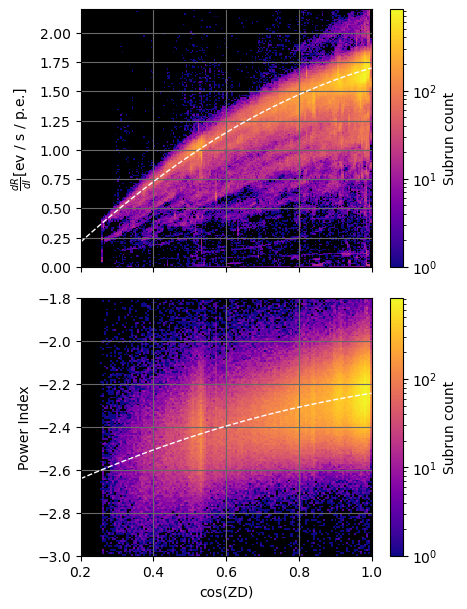

In [6]:
nanmask = np.isnan(merged_dict["cosmics_rate_at_422_pe"])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4.5, 6), sharex=True)
hist1 = ax1.hist2d(
    np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask], 
    np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask], 
    bins=(np.linspace(0.2, 1, 200), np.linspace(0, 2.2, 200)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)

hist2 = ax2.hist2d(
    np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask], 
    np.array(merged_dict["cosmics_spectral_index"])[~nanmask], 
    bins=(np.linspace(0.2, 1, 150), np.linspace(-3, -1.8, 150)),
    norm=matplotlib.colors.LogNorm(),
    cmap="plasma"
)
fig.colorbar(hist1[3], label="Subrun count")
fig.colorbar(hist2[3], label="Subrun count")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
fig.tight_layout()
ax2.set_xlabel("cos(ZD)")
ax1.set_ylabel("$\\frac{dR}{dI}$[ev / s / p.e.]")
ax2.set_ylabel("Power Index")


x = np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask] 
y = np.array(merged_dict["cosmics_spectral_index"])[~nanmask]
popt, pcov = curve_fit(quadratic_func, x, y)
x_fit = np.linspace(0.2, max(x), 100)
y_fit = quadratic_func(x_fit, *popt)
ax2.plot(x_fit, y_fit, 'w', lw=1, ls="--")

x = np.cos(np.deg2rad(merged_dict["zd"]))[~nanmask]
y = np.array(merged_dict["cosmics_rate_at_422_pe"])[~nanmask]
popt, pcov = curve_fit(quadratic_func, x, y)
x_fit = np.linspace(0.2, max(x), 100)
y_fit = quadratic_func(x_fit, *[-1.2,  3.3, -0.4])
ax1.plot(x_fit, y_fit, 'w', lw=1, ls="--")


plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

In [7]:
str_dchecks = "datacheck_"
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
main_name = f"{str_dchecks}dl1_LST-1.Run?????"
total_dl1a_runwise = np.sort(glob.glob(dl1_root + "*/" + f"{main_name}.h5") + glob.glob(dl1_root + f"{main_name}.h5"))

lengroups = 100
print(f"Amount of jobs is {np.ceil(len(total_dl1a_runwise) / lengroups)}")

njobs = int(np.ceil(len(total_dl1a_runwise) / lengroups))

for n in range(njobs):
    im = n * lengroups
    iM = (n + 1) * lengroups if (n + 1) * lengroups < len(total_dl1a_runwise) else len(total_dl1a_runwise)
    string = f"{im},{iM}"
    
    # !sbatch -p short bash_get_intensities.sh $string

Amount of jobs is 101.0


## Wait for the jobs to finish and then run

In [8]:
%%time
counts = []
intensity_points = []

files = glob.glob("./objects/tmp/*")

for i, file in enumerate(files):
    print(i, "/", len(files))
    
    with open(file, "rb") as f:
        _data = pickle.load(f)
    _i, _c = _data
    counts = counts + _c
    intensity_points = intensity_points + _i
    

0 / 101
1 / 101
2 / 101
3 / 101
4 / 101
5 / 101
6 / 101
7 / 101
8 / 101
9 / 101
10 / 101
11 / 101
12 / 101
13 / 101
14 / 101
15 / 101
16 / 101
17 / 101
18 / 101
19 / 101
20 / 101
21 / 101
22 / 101
23 / 101
24 / 101
25 / 101
26 / 101
27 / 101
28 / 101
29 / 101
30 / 101
31 / 101
32 / 101
33 / 101
34 / 101
35 / 101
36 / 101
37 / 101
38 / 101
39 / 101
40 / 101
41 / 101
42 / 101
43 / 101
44 / 101
45 / 101
46 / 101
47 / 101
48 / 101
49 / 101
50 / 101
51 / 101
52 / 101
53 / 101
54 / 101
55 / 101
56 / 101
57 / 101
58 / 101
59 / 101
60 / 101
61 / 101
62 / 101
63 / 101
64 / 101
65 / 101
66 / 101
67 / 101
68 / 101
69 / 101
70 / 101
71 / 101
72 / 101
73 / 101
74 / 101
75 / 101
76 / 101
77 / 101
78 / 101
79 / 101
80 / 101
81 / 101
82 / 101
83 / 101
84 / 101
85 / 101
86 / 101
87 / 101
88 / 101
89 / 101
90 / 101
91 / 101
92 / 101
93 / 101
94 / 101
95 / 101
96 / 101
97 / 101
98 / 101
99 / 101
100 / 101
CPU times: user 3min 29s, sys: 47.9 s, total: 4min 17s
Wall time: 6min 59s


In [9]:
str_dchecks = "datacheck_"
dl1_root = "/fefs/aswg/data/real/DL1/*/v0.*/tailcut84/"
main_name = f"{str_dchecks}dl1_LST-1.Run?????"
total_dl1a_runwise = np.sort(glob.glob(dl1_root + "*/" + f"{main_name}.h5") + glob.glob(dl1_root + f"{main_name}.h5"))

tab = tables.open_file(total_dl1a_runwise[0])

binstab = tab.root.dl1datacheck.histogram_binning.col("hist_intensity")[0]
tab.close()

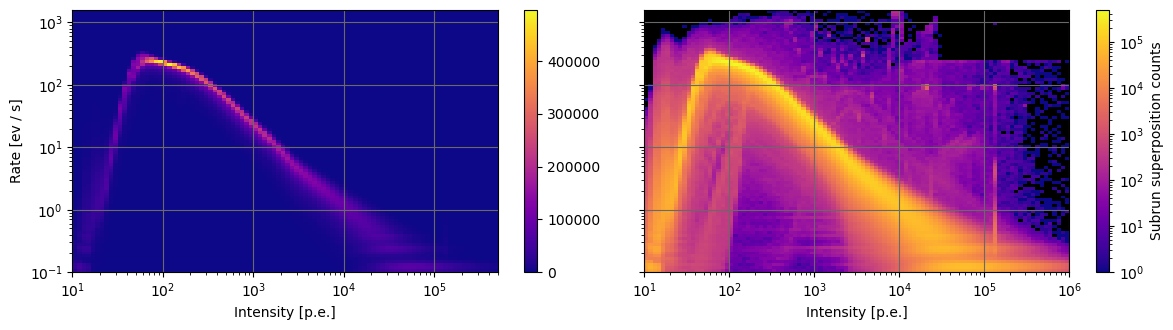

In [10]:
N = 90
bins = (binstab, np.logspace(-1, 3.2, N))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3.4), sharey=True)
hist1 = ax1.hist2d(intensity_points, counts, bins,
                 cmap="plasma")
fig.colorbar(hist1[3],)

hist2 = ax2.hist2d(intensity_points, counts, bins, 
                 norm=matplotlib.colors.LogNorm(),
                 cmap="plasma")
fig.colorbar(hist2[3], label="Subrun superposition counts")

ax1.set_ylabel("Rate [ev / s]")
for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
    ax.loglog()
    ax.set_xlabel("Intensity [p.e.]")
ax1.set_xlim(1e1, 5e5)
fig.tight_layout()


# plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()

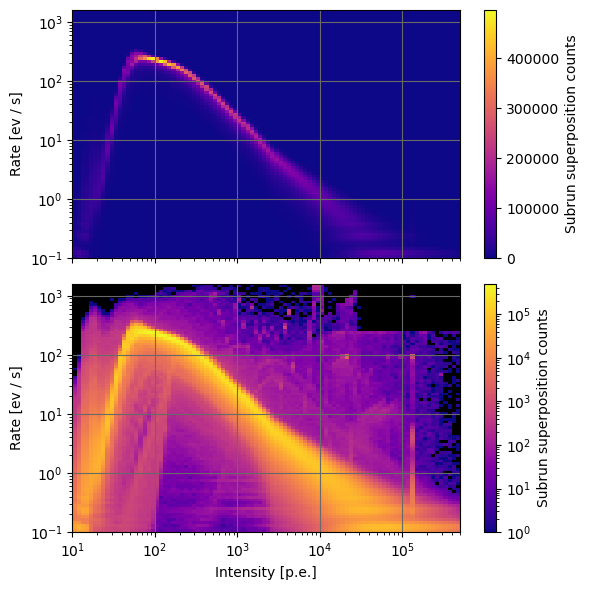

In [11]:
N = 90
bins = (binstab, np.logspace(-1, 3.2, N))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
hist1 = ax1.hist2d(intensity_points, counts, bins,
                 cmap="plasma")
fig.colorbar(hist1[3], label="Subrun superposition counts")

hist2 = ax2.hist2d(intensity_points, counts, bins, 
                 norm=matplotlib.colors.LogNorm(),
                 cmap="plasma")
fig.colorbar(hist2[3], label="Subrun superposition counts")


for ax in [ax1, ax2]:
    ax.set_facecolor("k")
    ax.grid(color="dimgray")
    ax.loglog()
    
    ax.set_ylabel("Rate [ev / s]")
ax1.set_xlim(1e1, 5e5)
ax2.set_xlabel("Intensity [p.e.]")
fig.tight_layout()


plt.savefig(f"plots/total.png", bbox_inches="tight", dpi=300)
plt.show()